<a href="https://colab.research.google.com/github/ZoliN/colab/blob/main/MODNet_Inference_with_onnx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MODNet - Inference with onnx

This notebook is the modified version of the main [colab demo](https://colab.research.google.com/drive/1GANpbKT06aEFiW-Ssx0DQnnEADcXwQG6?usp=sharing#scrollTo=JOmYOHKfgQ5Y). Refer it for more information. 


In this demo, we provide a very high performance **inference ready onnx model** for image matting. It also supports dynamic input and output shapes. <b><font color='#00FF0'>The inference time is also very less and you don't need **GPU** to run it. </font></b>

## 1. Preparation

Clone the repository and download the pretrained model.

In [ ]:
!pip install onnx onnxruntime
import os

# clone the repository
%cd /content
if not os.path.exists('MODNet'):
  !git clone https://github.com/manthan3C273/MODNet
%cd MODNet/

# dowload the onnx model for image matting
model = 'modnet.onnx'
if not os.path.exists(model):
  !gdown --id 1cgycTQlYXpTh26gB9FTnthE7AvruV8hd \
          -O pretrained/modnet.onnx

## 2. Upload image

Upload portrait images to be processed (only PNG and JPG format are supported). 

Download demo image. Photo by Charlotte May from [Pexels](https://www.pexels.com/photo/unrecognizable-asian-woman-with-rucksack-in-town-5965592/)

In [ ]:
# dowload image
image = 'image.jpg'
if not os.path.exists(image):
  !gdown --id 1fkyh03NEuSwvjFttYVwV7TjnJML04Xn6 \
          -O image.jpg

## 3. Inference

Run the following command for alpha matte prediction.

In [15]:
%cd /content/MODNet
!python demo/image_matting/Inference_with_ONNX/inference_onnx.py \
        --image-path=/content/image.jpg \
        --output-path=matte.png \
        --model-path=/content/MODNet/pretrained/modnet.onnx

/content/MODNet


In [ ]:
!pip install onnxsim onnxruntime
!onnxsim /content/MODNet/pretrained/modnet.onnx /content/MODNet/pretrained/modnet_672.onnx --overwrite-input-shape 1,3,672,512


In [ ]:
#!pip install onnx-tf
!python -m onnxruntime.tools.convert_onnx_models_to_ort --target_platform arm --save_optimized_onnx_model /content/model-small_16.onnx

In [ ]:
#!pip install onnx onnxconverter-common
import onnx
from onnxconverter_common import float16

model = onnx.load("/content/MODNet/pretrained/modnet.onnx")
model_fp16 = float16.convert_float_to_float16(model, keep_io_types=True)
onnx.save(model_fp16, "/content/MODNet/pretrained/modnet_16.onnx")

In [ ]:
import onnx
from onnxruntime.quantization import quantize_dynamic, QuantType

model_fp32 = '/content/MODNet/pretrained/modnet.onnx'
model_quant = '/content/MODNet/pretrained/modnetquant.onnx'
quantized_model = quantize_dynamic(model_fp32, model_quant,weight_type=QuantType.QUInt8, optimize_model=False)
#quantized_model = quantize_dynamic(model_fp32, model_quant)

## 4. Visualization

Display the results (from left to right: image, foreground, and alpha matte)

In [ ]:
import numpy as np
from PIL import Image

def combined_display(image, matte):
  # calculate display resolution
  w, h = image.width, image.height
  rw, rh = 800, int(h * 800 / (3 * w))
  
  # obtain predicted foreground
  image = np.asarray(image)
  if len(image.shape) == 2:
    image = image[:, :, None]
  if image.shape[2] == 1:
    image = np.repeat(image, 3, axis=2)
  elif image.shape[2] == 4:
    image = image[:, :, 0:3]
  matte = np.repeat(np.asarray(matte)[:, :, None], 3, axis=2) / 255
  foreground = image * matte + np.full(image.shape, 255) * (1 - matte)
  
  # combine image, foreground, and alpha into one line
  combined = np.concatenate((image, foreground, matte * 255), axis=1)
  combined = Image.fromarray(np.uint8(combined)).resize((rw, rh))
  return combined

# visualize all images

image = Image.open('image.jpg')
matte = Image.open('matte.png')
display(combined_display(image, matte))

## 5. Download image

Image with transparent background will be saved and downloaded. 

In [ ]:
image.putalpha(matte)
image.save('transparent_img.png')

from google.colab import files
files.download('transparent_img.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/content
 Write image to: output.png


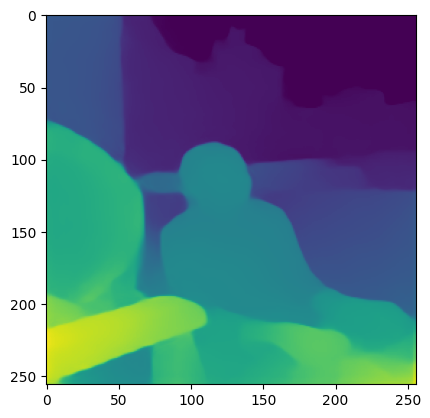

In [14]:
%cd /content
#img = img[837:2700, 600:2000,:]
#img = img[1237:2700, 600:2000,:]
import cv2
import tensorflow as tf
import urllib.request
import matplotlib.pyplot as plt

url, filename = ("https://github.com/intel-isl/MiDaS/releases/download/v2/dog.jpg", "dog.jpg")
urllib.request.urlretrieve(url, filename)

url, filename = ("https://github.com/intel-isl/MiDaS/releases/download/v2_1/model_opt.tflite", "model_opt.tflite")
urllib.request.urlretrieve(url, filename)

# input
img = cv2.imread('image.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.0

img_resized = tf.image.resize(img, [256,256], method='bicubic', preserve_aspect_ratio=False)
#img_resized = tf.transpose(img_resized, [2, 0, 1])
img_input = img_resized.numpy()
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
img_input = (img_input - mean) / std
reshape_img = img_input.reshape(1,256,256,3)
tensor = tf.convert_to_tensor(reshape_img, dtype=tf.float32)

# load model
#interpreter = tf.lite.Interpreter(model_path="/content/saved_model/model-small_float32.tflite")
interpreter = tf.lite.Interpreter(model_path="/content/model_opt.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_shape = input_details[0]['shape']

# inference
interpreter.set_tensor(input_details[0]['index'], tensor)
interpreter.invoke()
output = interpreter.get_tensor(output_details[0]['index'])
output = output.reshape(256, 256)
             
# output file
#prediction = cv2.resize(output, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)
prediction = output
print(" Write image to: output.png")
depth_min = 0 #prediction.min()
depth_max = prediction.max()
img_out = (255 * (prediction - depth_min) / (depth_max - depth_min)).astype("uint8")

cv2.imwrite("output.png", img_out)
plt.imshow(img_out)

In [ ]:
%cd /content
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from time import time

#new_model = tf.keras.models.load_model('out3')
model = tf.saved_model.load('outselfie').signatures["serving_default"] 


inpath = '/content/MODNet/image.jpg'
image = tf.io.read_file(inpath)
image = tf.image.decode_png(image, dtype=tf.uint8, channels=3)
image = image[0000:2000, 500:2000,:]
#image = image[1600:2700, 800:1900,:]
print(np.max(image))


image = (tf.image.resize(images=image, size=[256, 256]))
image = tf.cast(image, tf.float32) / 255.0
image = tf.expand_dims(image, 0)

t1 = time()
prediction = model(image)['Identity']
t2 = time()
elapsed = t2 - t1
print('Elapsed time is %f seconds.' % elapsed)

bg, prediction = tf.split(prediction, 2, 3)
#print(outp)
#prediction = tf.where(prediction > bg, 1.0, 0.0)
segres = prediction
prediction = prediction.numpy()
prediction = np.squeeze(prediction)

print(" Write image to: output.png")
depth_min = prediction.min()
depth_max = prediction.max()
img_out = (255 * (prediction - depth_min) / (depth_max - depth_min)).astype("uint8")

cv2.imwrite("depth.png", cv2.cvtColor(prediction*255.0, cv2.COLOR_BGR2RGB) )
plt.imshow(img_out)

In [1]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
!wget https://github.com/isl-org/MiDaS/releases/download/v2_1/model-small.onnx

In [ ]:
!pip install onnx onnxconverter-common
import onnx
from onnxconverter_common import float16

model = onnx.load("/content/model-small.onnx")
model_fp16 = float16.convert_float_to_float16(model, keep_io_types=True)
onnx.save(model_fp16, "/content/model-small_16.onnx")

In [ ]:
!onnx2tf -i /content/model_opt.onnx  -b 1 -cotof -cotoa 1e-1 

In [ ]:
!pip install -U onnx==1.13.1 \
&& pip install -U onnxruntime==1.13.1 \
&& pip install -U onnxsim==0.4.17 \
&& pip install -U onnx2tf \
&& pip install -U h5py==3.7.0 \
&& pip install -U nvidia-pyindex \
&& pip install -U onnx-graphsurgeon \
&& pip install -U  sne4onnx \
&& pip install -U sng4onnx

#&& pip install -U simple_onnx_processing_tools \



In [ ]:
!pip install -U  sne4onnx sng4onnx
#!pip install -U onnx_tf

In [ ]:
#img = img[837:2700, 600:2000,:]
#img = img[1237:2700, 600:2000,:]
import cv2
import tensorflow as tf
import urllib.request
import matplotlib.pyplot as plt
import numpy as np


# input
img = cv2.imread('/content/image.jpg')
img = cv2.resize(img, (512,672), 0, 0, cv2.INTER_AREA)
cv2.imwrite("ds.png", img)
img = (cv2.cvtColor(img, cv2.COLOR_BGR2RGB) - 127.5) / 127.0

#img_resized = tf.image.resize(img, [672,512], method='bilinear', preserve_aspect_ratio=False)
#img_resized = tf.transpose(img_resized, [2, 0, 1])
#img_input = img_resized.numpy()

reshape_img = img.reshape(1,672,512,3)

tensor = tf.convert_to_tensor(reshape_img, dtype=tf.float32)

# load model
interpreter = tf.lite.Interpreter(model_path="/content/model.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_shape = input_details[0]['shape']

# inference
interpreter.set_tensor(input_details[0]['index'], tensor)
interpreter.invoke()
output = interpreter.get_tensor(output_details[0]['index'])
output = output.reshape(672, 512)
             
# output file
prediction = output
print(" Write image to: output.png")
img_out = (255 * prediction ).astype("uint8")

cv2.imwrite("output.png", img_out)
plt.imshow(img_out)

In [ ]:
from onnx import checker as ch
from onnx import helper as h
def save_new_model(opset_version, nodes, graph, out_path, verbose=True):
    if verbose:
        print("Creating new fixed graph...")
    # * create a new graph with new nodes.
    new_graph = h.make_graph(
        nodes,
        graph.name,
        graph.input,
        graph.output,
        initializer=graph.initializer,  # The initializer holds all non-constant weights.
    )
    if verbose:
        print("Creating new fixed model...")
    new_model = h.make_model(new_graph, producer_name="onnx-fix-nodes")
    new_model.opset_import[0].version = opset_version
    ch.check_model(new_model)
    if verbose:
        print(f"Saving new model as: {out_path}")
    onnx.save_model(new_model, out_path)


def fix_onnx_resize_nodes(model_path: str, out_path: str, verbose=True):
    """
    Method to fix resize nodes giving the following error in Tensorflow
    conversions:
    - "Resize coordinate_transformation_mode=pytorch_half_pixel is not supported in Tensorflow"
    """
    if verbose:
        print(f"Loading Model: {model_path}")
    # * load model.
    model = onnx.load_model(model_path)
    ch.check_model(model)
    # * get model opset version.
    opset_version = model.opset_import[0].version
    graph = model.graph

    new_nodes = []
    if verbose:
        print("Fixing Resize nodes...")
    for i, node in enumerate(graph.node):
        if node.op_type == "Resize":
            print(node)
            new_resize = onnx.helper.make_node(
                'Resize',
                inputs=node.input,
                outputs=node.output,
                name=node.name,
                coordinate_transformation_mode='half_pixel',  # Instead of pytorch_half_pixel, unsupported by Tensorflow
                mode='linear',
            )
            # Update node
            new_nodes += [new_resize]
        else:
            new_nodes += [node]

    save_new_model(opset_version=opset_version, graph=graph, nodes=new_nodes,
                   out_path=out_path, verbose=verbose)

In [ ]:
fix_onnx_resize_nodes('/content/model_opt.onnx', '/content/model_optfixed.onnx')

In [ ]:
!pip install tflite2onnx

In [ ]:
import tflite2onnx

tflite_path = '/content/model_opt.tflite'
onnx_path = '/content/model_opt.onnx'

tflite2onnx.convert(tflite_path, onnx_path)

In [ ]:
#!cp -r /content/gdrive/MyDrive/hdrnet/hdrnet /content/
%cd /content/hdrnet
import hdrnet.guided_filter as gf
import tensorflow as tf
import cv2
import numpy as np
from importlib import reload
reload(gf)


# depth = tf.io.read_file("/content/depth.png")
# depth = tf.image.decode_png(depth, dtype=tf.uint8, channels=1)
#matte = tf.io.read_file("/content/matte.png")
#matte = tf.image.decode_png(matte, dtype=tf.uint8, channels=1)
dir = 'im8'

imgc = cv2.imread('/content/' + dir +  '/image.jpg')
img = cv2.cvtColor(imgc, cv2.COLOR_BGR2GRAY)
img = img.astype('float') / 255.0
rows = np.shape(img)[0]
cols = np.shape(img)[1]

img4 = cv2.resize(img, (cols//4,rows//4), 0, 0, cv2.INTER_LINEAR)


matte1 = cv2.imread('/content/' + dir +  '/matte.png')
matte1 = np.split(matte1,3,2)[0].astype('float') / 255.0
erodedMatte = cv2.erode(matte1, np.ones((3, 3), 'uint8'))
erodedMatte = cv2.resize(erodedMatte, (cols,rows), 0, 0, cv2.INTER_LINEAR)

matte4 = cv2.resize(matte1, (cols//4,rows//4), 0, 0, cv2.INTER_LINEAR)
matte = cv2.resize(matte1, (cols,rows), 0, 0, cv2.INTER_LINEAR)
cv2.imwrite("/content/mattehr.png", (np.clip(matte * 255.0, 0.,255.) ).astype("uint8") )

w = np.where(matte4 > 0.1, 0.0, 1.0 - matte4) 
wimg = img4 * w
wimgw = np.dstack((wimg, w))
blurred = cv2.blur(wimgw, (5,5))
imb, wb = np.split(blurred,2,2)
meanim = np.where(wb >= 0.01, imb / wb, 0.0) 

wimg = img4 * img4 * w
wimgw = np.dstack((wimg, w))
blurred = cv2.blur(wimgw, (5,5))
imb, wb = np.split(blurred,2,2)
mean2im = np.where(wb >= 0.01, imb / wb, 0.0) 

varim = mean2im - meanim * meanim
varim = cv2.dilate(varim, np.ones((3, 3), 'uint8'))
#varim = cv2.dilate(varim, np.ones((3, 3), 'uint8'))


varim = tf.squeeze(varim)
var_min = 0
var_max = 0.06
varnormalized = np.clip(((varim - var_min) / (var_max - var_min)), 0.,1.)
varim1 = (varnormalized * 255.).astype("uint8")
cv2.imwrite('/content/var1.png', varim1.astype("uint8") )

mitigateFactor = 1.0 + 6.0 * varnormalized

matte4 = np.power(matte4, mitigateFactor)
#matte = cv2.resize(matte4, (cols,rows), 0, 0, cv2.INTER_LINEAR)
cv2.imwrite("/content/mattehr2.png", (np.clip(matte * 255.0, 0.,255.) ).astype("uint8") )


#img = cv2.resize(img, (512,672), 0, 0, cv2.INTER_AREA)
#matte = tf.image.resize(images=matte, size=[4080, 3072])

erodedMatte = tf.cast(erodedMatte, tf.float32) 

matte = tf.cast(matte, tf.float32) 
img = tf.cast(img, tf.float32) 

# depth = tf.cast(depth, tf.float32) / 255.0
# dilatedDepth = cv2.erode(depth.numpy(), np.ones((3, 3), 'uint8'))

# depth = tf.expand_dims(depth, 0)
img = tf.expand_dims(img, 0)
img = tf.expand_dims(img, 3)
matte = tf.expand_dims(matte, 0)
matte = tf.expand_dims(matte, 3)
erodedMatte = tf.expand_dims(erodedMatte, 0)
erodedMatte = tf.expand_dims(erodedMatte, 3)
# dilatedDepth = tf.expand_dims(dilatedDepth, 0)
# dilatedDepth = tf.expand_dims(dilatedDepth, 3)
print(tf.shape(img))
print(tf.shape(matte))
print(tf.shape(erodedMatte))

# depth = tf.image.resize(images=depth, size=[672, 512])
# dilatedDepth = tf.image.resize(images=dilatedDepth, size=[672, 512])
# cv2.imwrite("/content/depthout.png", (255 * tf.squeeze(depth).numpy() ).astype("uint8") )

# depthlr = tf.image.resize(images=depth, size=[672//2, 512//2], method='nearest')
fgdiv=4
imglr = tf.image.resize(images=img, size=[rows//fgdiv, cols//fgdiv], method='nearest')
mattelr = tf.image.resize(images=matte, size=[rows//fgdiv, cols//fgdiv], method='nearest')
erodedMattelr = tf.image.resize(images=erodedMatte, size=[rows//fgdiv, cols//fgdiv], method='nearest')
# dilatedDepthlr = tf.image.resize(images=dilatedDepth, size=[672//2, 512//2], method='nearest')

#img = gf.fast_guided_filter(mattelr, depthlr, matte, depthlr, 2, eps=1e-8, nhwc=True)
img = gf.fast_guided_filter(imglr, mattelr, img, 1, eps=0.01*0.01, nhwc=True)

img = tf.squeeze(img).numpy()
mitigateFactor = cv2.resize(mitigateFactor, (cols,rows), 0, 0, cv2.INTER_LINEAR)
img = np.power(img, mitigateFactor)
#img = np.where(mitigateFactor < 1.01, img, 0.0)

#cv2.imwrite("/content/mitigateFactor.png", (np.clip(255.0 * (mitigateFactor - 1.0), 0.,255.) ).astype("uint8") )

cv2.imwrite("/content/out.png", (np.clip(255 * img, 0.,255.) ).astype("uint8") )


In [ ]:
import hdrnet.guided_filter as gf
import tensorflow as tf
import cv2
import numpy as np
from importlib import reload
reload(gf)


img = cv2.imread('/content/image.jpg')
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (512,672), 0, 0, cv2.INTER_AREA)

matte = cv2.imread('/content/matte.png')

matteEroded = cv2.erode(matte, np.ones((3, 3), 'uint8'))

img = img.astype("float") / 255.0
matte = matte.astype("float") / 255.0
print(np.shape(matte))

matteThres = np.where(matte > 0.1, 1.0, 0.0)

matteEroded = cv2.erode(matteThres, np.ones((3, 3), 'uint8'))
matteEroded = cv2.erode(matteEroded, np.ones((3, 3), 'uint8'))
matteBorder = matteThres - matteEroded

imgM = img * matte
imgMT = img * matteThres
img2 = img * matteEroded
img2 = cv2.dilate(img2, np.ones((3, 3), 'uint8'))
img2 = cv2.dilate(img2, np.ones((3, 3), 'uint8'))

mult = 1.0 / (1.0 + np.sum((img - img2) ** 2, axis=2, keepdims = True)*20.)
mult*=(np.split(matteThres,3,2)[0] - np.split(matteEroded,3,2)[0])

matte = matte * np.where(mult == 0.0, 1.0, mult)
imgM2 = img * matte

matte = np.split(matte,3,2)[0]

cv2.imwrite("/content/outM.png", (np.clip(255 * tf.squeeze(imgM), 0.,255.) ).astype("uint8") )
cv2.imwrite("/content/out2.png", (np.clip(255 * tf.squeeze(img2), 0.,255.) ).astype("uint8") )
cv2.imwrite("/content/outMT.png", (np.clip(255 * tf.squeeze(imgMT), 0.,255.) ).astype("uint8") )
cv2.imwrite("/content/out2.png", (np.clip(255 * tf.squeeze(img2), 0.,255.) ).astype("uint8") )
cv2.imwrite("/content/mult.png", (np.clip(255 * tf.squeeze(mult), 0.,255.) ).astype("uint8") )
cv2.imwrite("/content/mattemod.png", (np.clip(255 * tf.squeeze(matte), 0.,255.) ).astype("uint8") )
cv2.imwrite("/content/outM2.png", (np.clip(255 * tf.squeeze(imgM2), 0.,255.) ).astype("uint8") )



(672, 512, 3)


True